## Урок 8. Домашнее задание

Построим вариационный автоэнкодер для датасета __Fashion_MNIST__. Для начала импортируем необходимые библиотеки.

In [92]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

По аналогии с уроком создадим слой, который будет отвечать за генерацию случайной точки, которую мы будем передавать в дальнейшем в декодер.

In [93]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Сначала воспользуемся энкодером и декодером, представленными на уроке, со скрытым пространством размера 2.

In [94]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 14, 14, 32)   320         input_25[0][0]                   
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 7, 7, 64)     18496       conv2d_32[0][0]                  
__________________________________________________________________________________________________
flatten_14 (Flatten)            (None, 3136)         0           conv2d_33[0][0]                  
____________________________________________________________________________________________

In [95]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_25 (Dense)             (None, 3136)              9408      
_________________________________________________________________
reshape_10 (Reshape)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_32 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_33 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_34 (Conv2DT (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

Повторим класс модели, представленный на уроке, который описывает подсчет ошибок на каждом шаге обучения.

In [96]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Теперь обучим построенную модель для изображений из датасета __Fashion_MNIST__.

In [97]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
fashion_mnist_pics = np.concatenate([x_train, x_test], axis=0)
fashion_mnist_pics = np.expand_dims(fashion_mnist_pics, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(fashion_mnist_pics, epochs=20, batch_size=128)

Epoch 1/20
547/547 [==============================] - 5s 7ms/step - loss: 335.1735 - reconstruction_loss: 330.4966 - kl_loss: 4.6769
Epoch 2/20
547/547 [==============================] - 4s 7ms/step - loss: 277.1433 - reconstruction_loss: 271.7764 - kl_loss: 5.3669
Epoch 3/20
547/547 [==============================] - 4s 7ms/step - loss: 271.0714 - reconstruction_loss: 266.3907 - kl_loss: 4.6807
Epoch 4/20
547/547 [==============================] - 4s 7ms/step - loss: 268.5446 - reconstruction_loss: 264.0851 - kl_loss: 4.4595
Epoch 5/20
547/547 [==============================] - 4s 7ms/step - loss: 267.1065 - reconstruction_loss: 262.7628 - kl_loss: 4.3437
Epoch 6/20
547/547 [==============================] - 4s 7ms/step - loss: 265.9010 - reconstruction_loss: 261.6160 - kl_loss: 4.2850
Epoch 7/20
547/547 [==============================] - 4s 7ms/step - loss: 265.0003 - reconstruction_loss: 260.7675 - kl_loss: 4.2328
Epoch 8/20
547/547 [==============================] - 4s 7ms/step - l

Суммарная ошибка постепенно сокращается. Посмотрим на визуализацию построенного вариационного энкодера.

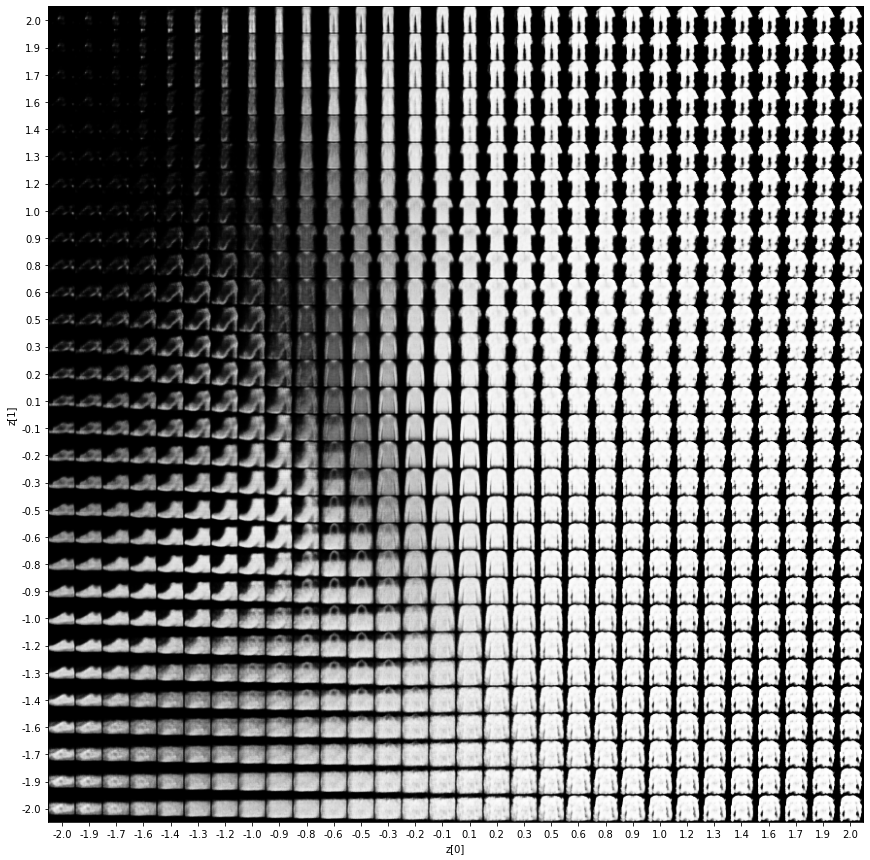

In [98]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((size * n, size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            pic = x_decoded[0].reshape(size, size)
            figure[
                i * size : (i + 1) * size,
                j * size : (j + 1) * size,
            ] = pic

    plt.figure(figsize=(figsize, figsize))
    start_range = size // 2
    end_range = (n - 1) * size + start_range + 1
    pixel_range = np.arange(start_range, end_range, size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

Теперь попробуем усложнить энкодер/декодер, в частности увеличить размер скрытого пространства.

In [107]:
latent_dim = 5

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 14, 14, 64)   640         input_31[0][0]                   
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 7, 7, 128)    73856       conv2d_38[0][0]                  
__________________________________________________________________________________________________
flatten_17 (Flatten)            (None, 6272)         0           conv2d_39[0][0]                  
____________________________________________________________________________________________

In [108]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 5)]               0         
_________________________________________________________________
dense_31 (Dense)             (None, 6272)              37632     
_________________________________________________________________
reshape_13 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_41 (Conv2DT (None, 14, 14, 128)       147584    
_________________________________________________________________
conv2d_transpose_42 (Conv2DT (None, 28, 28, 64)        73792     
_________________________________________________________________
conv2d_transpose_43 (Conv2DT (None, 28, 28, 1)         577       
Total params: 259,585
Trainable params: 259,585
Non-trainable params: 0
_____________________________________________________

Обучим вариационный энкодер.

In [109]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(fashion_mnist_pics, epochs=50, batch_size=32)

Epoch 1/50
2188/2188 [==============================] - 13s 6ms/step - loss: 259.3093 - reconstruction_loss: 255.5873 - kl_loss: 3.7219
Epoch 2/50
2188/2188 [==============================] - 12s 6ms/step - loss: 239.0939 - reconstruction_loss: 235.5738 - kl_loss: 3.5201
Epoch 3/50
2188/2188 [==============================] - 12s 6ms/step - loss: 235.3093 - reconstruction_loss: 231.8468 - kl_loss: 3.4625
Epoch 4/50
2188/2188 [==============================] - 12s 6ms/step - loss: 233.5072 - reconstruction_loss: 230.0749 - kl_loss: 3.4322
Epoch 5/50
2188/2188 [==============================] - 12s 6ms/step - loss: 232.4053 - reconstruction_loss: 228.9893 - kl_loss: 3.4160
Epoch 6/50
2188/2188 [==============================] - 12s 6ms/step - loss: 231.7062 - reconstruction_loss: 228.2956 - kl_loss: 3.4106
Epoch 7/50
2188/2188 [==============================] - 12s 6ms/step - loss: 231.2043 - reconstruction_loss: 227.8019 - kl_loss: 3.4024
Epoch 8/50
2188/2188 [==========================

Нам удалось добиться уменьшения обеих составляющих ошибки. Лоссы стабилизировались, на поздних эпохах расстояние Кульбака-Лейблера начало увеличиваться. Визуализируем полученные результаты, зафиксировав несколько измерений.

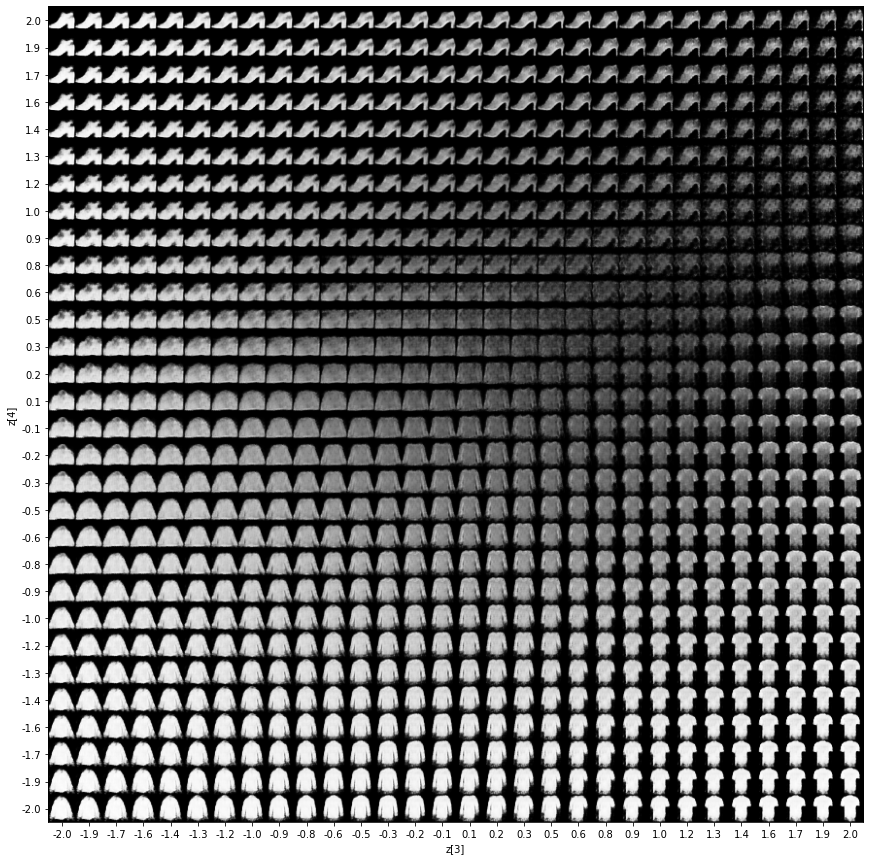

In [110]:
def plot_latent_5D(encoder, decoder):
    n = 30
    size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((size * n, size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[1, 1, 0, xi, yi]])
            x_decoded = decoder.predict(z_sample)
            pic = x_decoded[0].reshape(size, size)
            figure[
                i * size : (i + 1) * size,
                j * size : (j + 1) * size,
            ] = pic

    plt.figure(figsize=(figsize, figsize))
    start_range = size // 2
    end_range = (n - 1) * size + start_range + 1
    pixel_range = np.arange(start_range, end_range, size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[3]")
    plt.ylabel("z[4]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_5D(encoder, decoder)

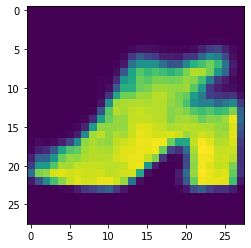

In [112]:
x_decoded = decoder.predict([[1, 1, 0, -1.4, 1.6]])
plt.imshow(x_decoded[0,:,:,0])
plt.show()

------
#### Приложение

In [121]:
# размерность - 120
latent_dim = 120

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 14, 14, 64)   640         input_38[0][0]                   
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 7, 7, 128)    73856       conv2d_44[0][0]                  
__________________________________________________________________________________________________
flatten_20 (Flatten)            (None, 6272)         0           conv2d_45[0][0]                  
____________________________________________________________________________________________

In [122]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 128, activation="leaky_relu")(latent_inputs)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="leaky_relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="leaky_relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 120)]             0         
_________________________________________________________________
dense_38 (Dense)             (None, 6272)              758912    
_________________________________________________________________
reshape_17 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_53 (Conv2DT (None, 14, 14, 128)       147584    
_________________________________________________________________
conv2d_transpose_54 (Conv2DT (None, 28, 28, 64)        73792     
_________________________________________________________________
conv2d_transpose_55 (Conv2DT (None, 28, 28, 1)         577       
Total params: 980,865
Trainable params: 980,865
Non-trainable params: 0
_____________________________________________________

In [123]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(fashion_mnist_pics, epochs=20, batch_size=128)

Epoch 1/20
547/547 [==============================] - 7s 11ms/step - loss: 249.2497 - reconstruction_loss: 247.2096 - kl_loss: 2.0400
Epoch 2/20
547/547 [==============================] - 6s 11ms/step - loss: 221.9749 - reconstruction_loss: 219.7617 - kl_loss: 2.2132
Epoch 3/20
547/547 [==============================] - 6s 11ms/step - loss: 218.9705 - reconstruction_loss: 216.8417 - kl_loss: 2.1288
Epoch 4/20
547/547 [==============================] - 6s 11ms/step - loss: 217.3700 - reconstruction_loss: 215.2999 - kl_loss: 2.0701
Epoch 5/20
547/547 [==============================] - 6s 11ms/step - loss: 216.2492 - reconstruction_loss: 214.2312 - kl_loss: 2.0180
Epoch 6/20
547/547 [==============================] - 6s 11ms/step - loss: 215.5011 - reconstruction_loss: 213.5266 - kl_loss: 1.9745
Epoch 7/20
547/547 [==============================] - 6s 11ms/step - loss: 214.9183 - reconstruction_loss: 212.9934 - kl_loss: 1.9248
Epoch 8/20
547/547 [==============================] - 6s 11ms/